In [14]:
import tensorflow as tf
from PIL import Image
from scipy.misc import imread, imshow,imresize
from glob import glob
from itertools import cycle,zip_longest
import numpy as np
import matplotlib.pyplot as plt
import imageio
import random
import os
from tensorflow.contrib import slim
from nets.inception_v3 import inception_v3,inception_v3_arg_scope
from datasets import dataset_utils
import time

In [2]:
random.seed(5)

In [3]:
def grouper(n, iterable, fillvalue=None):
  args = [iter(iterable)]*n
  return zip_longest(*args, fillvalue=fillvalue)

In [4]:
height_image = inception_v3.default_image_size
width_image = inception_v3.default_image_size

In [5]:
def get_images(data_dir, training, batch_size=10):
  height = height_image
  width = width_image
  if(training == True):
    data_dir = data_dir +"training/"
  else:
    data_dir = data_dir +"validation/"
  input_files_positive = glob(data_dir + "positive/*.jpg")
  input_files_negative = glob(data_dir + "negative/*.jpg")
  input_files_neutral = glob(data_dir + "neutral/*.jpg")
  #input_files_positive = glob(data_dir + "daisy/*.jpg")
  #input_files_negative = glob(data_dir + "roses/*.jpg")
  #input_files_neutral = glob(data_dir + "tulips/*.jpg")
  input_files = input_files_positive + input_files_negative + input_files_neutral
  labels = [np.array([0,0,1])]*len(input_files_positive) + [np.array([0,1,0])]*len(input_files_negative) + [np.array([1,0,0])]*len(input_files_neutral)
  label_files = list(zip(input_files,labels))
  label_files = random.sample(label_files,len(label_files))
  label_files_infinite = cycle(label_files)

  label_files_grouped = grouper(batch_size,label_files_infinite)
  while 1:
    image_names,labels = zip(*next(label_files_grouped))
    
    #can change image size - note - possibly investigate?
    image_files = [imresize(np.uint8(imageio.imread(fname)),(height,width)) for fname in image_names]
    
    yield zip(image_files,list(labels))


In [6]:
data_dir = "/Users/sashatn/Desktop/Cambridge/Michaelmas/Affective Computing (L44)/Mini-Project/data conversion/data_dir/"

In [7]:
x = get_images(data_dir,True,10)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


[1 0 0]
(299, 299, 3)


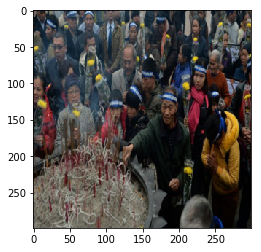

In [8]:
images, labels = map(list, zip(*next(x)))
print(labels[0])
print(images[0].shape)
plt.imshow(images[0])
plt.show()

In [9]:
total_num_images = 30
num_epochs = 3
batch_size = 10
initial_learning_rate = 0.001
learning_rate_decay_iterations = 2
num_epochs_before_decay = 10
num_batches_per_epoch = int(total_num_images / batch_size)
num_steps_per_epoch = num_batches_per_epoch 

In [12]:
checkpoints_dir = '/tmp/checkpoints'
url = "http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz"

if not tf.gfile.Exists(checkpoints_dir):
    tf.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading inception_v3_2016_08_28.tar.gz 100.0%
Successfully downloaded inception_v3_2016_08_28.tar.gz 100885009 bytes.


In [15]:
tf.reset_default_graph()

images = tf.placeholder(tf.float32,shape=[None,height_image,width_image,3])
labels = tf.placeholder(tf.float32,shape=[None,3])
learning_rate = tf.placeholder(tf.float32,shape=[])

with slim.arg_scope(inception_v3_arg_scope()):
    logits, _ = inception_v3(images, num_classes=3, is_training=True)
    
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
correct_prediction = tf.equal(tf.argmax(logits,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = slim.learning.create_train_op(cross_entropy, optimizer)

def feed_dict(batch_size, training, epoch):
  lr = initial_learning_rate
  if training == True:
    data = get_images(data_dir,training,batch_size)
  elif training == False:
    data = get_images(data_dir,training,batch_size)
  imgs, lbls = map(list, zip(*next(data)))
  if(epoch > num_epochs_before_decay and epoch % learning_rate_decay_iterations == 0):
    lr = 0.001*(10**(-epoch/100))
  return {images: imgs, labels: lbls, learning_rate: lr}


checkpoint_exclude_scopes=["InceptionV3/Logits", "InceptionV3/AuxLogits"]

exclusions = checkpoint_exclude_scopes
#review code!
variables_to_restore = []
for var in slim.get_model_variables():
    excluded = False
    for exclusion in exclusions:
        if var.op.name.startswith(exclusion):
            excluded = True
            break
    if not excluded:
        variables_to_restore.append(var)
#variables_to_restore = slim.get_variables_to_restore(exclude = checkpoint_exclude_scopes)
saver = tf.train.Saver(variables_to_restore)

with tf.Session() as sess:

 
  saver.restore(sess,os.path.join(checkpoints_dir, 'inception_v3.ckpt'))
  sess.run(tf.initialize_all_variables())
  
  total_loss_val = 0
  total_train_accuracy = 0
  total_val_accuracy = 0
  best_accuracy = 0
  avg_training_acc = 0
  avg_val_acc = 0
  start_time_per_epoch = 0
  time_elapsed_eval_per_epoch = 0
  time_elapsed_training_per_epoch = 0
  overall_training_time = 0
  
  overall_training_time = time.time()
  for i in range(num_epochs):
    
    best_acc_file = open(os.path.join(data_dir, 'accuracy/best_accuracy.txt'),"a") 
    all_acc_file = open(os.path.join(data_dir, 'accuracy/all_accuracy.txt'),"a") 
    
    start_time_per_epoch = time.time()
    for j in range(num_batches_per_epoch):
      print("Epoch %s, Batch %s" % (i,j))
      _,training_loss = sess.run([train_op, cross_entropy],feed_dict=feed_dict(batch_size,True))
      train_accuracy = accuracy.eval(feed_dict=feed_dict(batch_size,True))
      total_loss_val = total_loss_val + training_loss
      total_train_accuracy = total_train_accuracy + train_accuracy
    avg_training_acc = total_train_accuracy/num_batches_per_epoch
    print("--------------------------------------------------------------------")
    print("Epoch %s: training accuracy %s, training loss %s" % (i,avg_training_acc,total_loss_val))
    time_elapsed_training_per_epoch = time.time() - start_time_per_epoch
    for _ in range(num_batches_per_epoch):
      validation_accuracy = accuracy.eval(feed_dict=feed_dict(batch_size,False))
      total_val_accuracy = total_val_accuracy + validation_accuracy
    avg_val_acc = total_val_accuracy/num_batches_per_epoch
    print("Epoch %s: validation accuracy %s" % (i,avg_val_acc))
    print("--------------------------------------------------------------------")
    time_elapsed_eval_per_epoch = time.time() - start_time_per_epoch - time_elapsed_training_per_epoch
    all_acc_file.write("%s %s %s %s %s %s\n" % (i, total_loss_val, avg_training_acc, avg_val_acc, time_elapsed_training_per_epoch, time_elapsed_eval_per_epoch))
   
    #store model at best accuracy
    if avg_val_acc > best_accuracy:
      best_acc_file.write("Epoch %s: " % (i))
      best_acc_file.write("Best validation accuracy: %s\n" % (avg_val_acc))
      best_accuracy = avg_val_acc
      best_model_path = saver.save(sess, data_dir + 'best_model/')  
    
    total_loss_val = 0
    total_train_accuracy = 0
    total_val_accuracy = 0
    avg_training_acc = 0
    avg_val_acc = 0
    best_model_path = ""
    start_time = 0
    time_elapsed_eval = 0
    time_elapsed_training = 0
    
    best_acc_file.close()
    all_acc_file.close()
    
  overall_training_time = time.time() - overall_training_time
  print("Training time: %s" % overall_training_time)
  
      
  #features = graph.get_tensor_by_name('inception_v3/GlobalPool')
  #features_values = sess.run(features)
  #print (features_values[0])
  
  ## GLOBAL POOL???
    

INFO:tensorflow:Restoring parameters from /tmp/checkpoints/inception_v3.ckpt
Epoch 0, Batch 0


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Epoch 0, Batch 1
Epoch 0, Batch 2
--------------------------------------------------------------------
Epoch 0: training accuracy 0.366666674614, training loss 4.47604191303
Epoch 0: validation accuracy 0.433333349725
--------------------------------------------------------------------


NameError: name 'time_elapsed_training' is not defined